# Enzyme Data Extractor
This notebook automates the extraction, cleaning, and analysis of enzyme recognition sequences from a REBASE‐formatted dataset. It generates curated CSV files for downstream bioinformatics analyses.


## Imports

In [1]:
import os
import ssl
import certifi
import urllib.request
import re
import pandas as pd
import time
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from Bio import Entrez, SeqIO
import sys
import tempfile
from Bio.Blast.Applications import NcbimakeblastdbCommandline, NcbitblastnCommandline

/Users/mariacarvalho/Documents/GitHub/Bioinformatics-Project/.venv/lib/python3.10/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
os.environ["SSL_CERT_FILE"] = certifi.where()

print("Certificado SSL forçado para:", os.environ["SSL_CERT_FILE"])
response = urllib.request.urlopen("https://www.ncbi.nlm.nih.gov")
print("Conexão segura com NCBI! Status:", response.status)


Certificado SSL forçado para: /Users/mariacarvalho/Documents/GitHub/Bioinformatics-Project/.venv/lib/python3.10/site-packages/certifi/cacert.pem
Conexão segura com NCBI! Status: 200


In [3]:
txt_path = "Restriction Enzymes.txt"
csv_path = "enzyme_data_clean_from_txt.csv"


with open('Restriction Enzymes.txt', "r", encoding="utf-8") as f:
    content = f.read()


entries = re.findall(r"<1>.*?(?=<1>|$)", content, flags=re.DOTALL)

data = []
for entry in entries:
    name = re.search(r"<1>(.*)", entry)
    micro = re.search(r"<3>(.*)", entry)
    recog = re.search(r"<5>(.*)", entry)
    
    data.append({
        "ENZYME NAME": name.group(1).strip() if name else "",
        "MICROORGANISM": micro.group(1).strip() if micro else "",
        "RECOGNITION SEQUENCE": recog.group(1).strip() if recog else ""
    })

df = pd.DataFrame(data)

## Filtering Ambiguous Recognition Sequences

Remove any entries containing ambiguous bases (“?”) in their recognition sequences to ensure reliable downstream analysis.


In [4]:
df = df[~df["RECOGNITION SEQUENCE"].str.contains(r"\?", na=False)]

## Isolating *Escherichia coli* Entries

Select only those records corresponding to *E. coli*, focusing the dataset on our organism of interest.

In [5]:
df = df[df["MICROORGANISM"].str.contains("Escherichia coli", case=False, na=False)]

## Exporting the Cleaned Dataset

Save the filtered and normalized enzyme table to a CSV file for subsequent steps.

In [6]:
df.to_csv(csv_path, index=False)
print(f"File created: {csv_path}")

File created: enzyme_data_clean_from_txt.csv


## Matching Enzymes to Phage Host Data

Compare the cleaned enzyme dataset against phage host information (`host` and `lab_host` fields) to identify overlapping microbial hosts.


1. **Loads** two CSV files:
   - `enzyme_data_clean_from_txt.csv` (contains enzyme and microorganism info)
   - `phage_host.csv` (contains phage host and lab host data)
2. **Filters** the enzymes to include only those whose microorganism appears in either the `host` or `lab_host` columns of the phage dataset.
3. **Displays** the filtered results for review.


In [7]:
# Load the CSVs
df1 = pd.read_csv("enzyme_data_clean_from_txt.csv")  # This contains "microorganism"
df2 = pd.read_csv("phage_host.csv")  # This contains "host" and "lab_host"

# Option 1: Check matches either with "host" or "lab_host"
matches = df1[
    df1["MICROORGANISM"].isin(df2["Host"]) |
    df1["MICROORGANISM"].isin(df2["Lab_Host"])
]

print(matches)


       ENZYME NAME          MICROORGANISM RECOGNITION SEQUENCE
0             EciI       Escherichia coli         GGCGGA(11/9)
1        Eco9034II       Escherichia coli              GAAABCC
2       Eco13441IV       Escherichia coli              CANCATC
3     M.Eco9034Dam       Escherichia coli                 GATC
4    M.Eco13441Dam       Escherichia coli                 GATC
5     M.EcoEc67Dam       Escherichia coli                 GATC
6           EcoHAI       Escherichia coli               YGGCCR
7            EcoNI       Escherichia coli         CCTNN^NNNAGG
8          Eco29kI       Escherichia coli              CCGC^GG
9          EcoprrI       Escherichia coli       CCANNNNNNNRTGC
50           EcoBI     Escherichia coli B      TGANNNNNNNNTGCT
249      EcoO157SI  Escherichia coli O157             C(14/12)


##  Filtered enzyme entries matched to phage hosts

The table displays enzyme entries from _Escherichia coli_ whose associated microorganisms match either the `host` or `lab_host` fields in the phage host dataset.

Each row includes:
- **ENZYME NAME**: One or more enzymes grouped by recognition sequence.
- **MICROORGANISM**: The bacterial strain the enzyme originates from.
- **RECOGNITION SEQUENCE**: The DNA sequence each enzyme targets.

A total of **12 matching entries** were identified and are shown for further inspection.



In [8]:
# Load the CSVs
df1 = pd.read_csv("enzyme_data_clean_from_txt.csv")  # Contains "MICROORGANISM"
df2 = pd.read_csv("phage_host.csv")  # Contains "Host" e "Lab_Host"

# Check matches either with "host" or "lab_host"
df1["MICROORGANISM"] = df1["MICROORGANISM"].str.strip().str.lower()
df2["Host"] = df2["Host"].str.strip().str.lower()
df2["Lab_Host"] = df2["Lab_Host"].str.strip().str.lower()

# Find matches
matches = df1[
    df1["MICROORGANISM"].isin(df2["Host"]) |
    df1["MICROORGANISM"].isin(df2["Lab_Host"])
]


# Save in CSV
matches.to_csv("matched_microorganisms.csv", index=False)

print("'matched_microorganisms.csv' created.")

'matched_microorganisms.csv' created.


##  Extracting and structuring protein sequence data

Parse the REBASE‐formatted `protein_seqs.txt` file to build a structured DataFrame of protein metadata and their amino acid sequences.

1. **Reads** the `protein_seqs.txt` file line by line.
2. **Detects** new protein entries using the `>REBASE:` header marker.
3. **Parses** metadata fields (e.g., ID, name, organism) from tab-separated lines.
4. **Appends** all associated sequence lines to the current record.
5. **Handles** edge cases, such as the final record without an explicit end marker.
6. **Converts** the parsed data into a pandas DataFrame.
7. **Exports** the result to `protein_seqs.csv` for downstream analysis.


In [9]:
records = []
with open("protein_seqs.txt", "r") as f:
    current_record = {}
    sequence_lines = []
    for line in f:
        line = line.strip()
        if line.startswith(">REBASE:"):
            # Save the previous record if it exists
            if current_record:
                current_record["Sequence"] = " ".join(sequence_lines)
                records.append(current_record)
                sequence_lines = []
            # Parse the header line into fields
            fields = line[1:].split('\t')
            current_record = {}
            for field in fields:
                key, value = field.split(":", 1)
                current_record[key] = value
        elif line == "<>":
            # End of record
            if current_record:
                current_record["Sequence"] = " ".join(sequence_lines)
                records.append(current_record)
                current_record = {}
                sequence_lines = []
        elif line and not line.startswith(">"):
            sequence_lines.append(line)
    # Add the last record if file doesn't end with <>
    if current_record:
        current_record["Sequence"] = " ".join(sequence_lines)
        records.append(current_record)

# Convert to DataFrame
df = pd.DataFrame(records)


In [10]:
df.to_csv("protein_seqs.csv", index=False)

## Mapping Enzyme Names to Protein Sequences

Join the cleaned enzyme dataset with parsed protein records so each enzyme is linked to its corresponding sequence.


1. **Loads** two datasets:
   - `enzyme_data_clean_from_txt.csv`: Contains enzyme names and recognition data.
   - `protein_seqs.csv`: Contains parsed protein records from the REBASE file.
2. **Filters** the enzyme data to include only those that have a matching `REBASE` identifier in the protein dataset.
3. **Displays** the filtered list of enzyme entries with corresponding protein sequence matches.


In [11]:
# Load the CSV file
df1 = pd.read_csv("enzyme_data_clean_from_txt.csv")  

df2 = pd.read_csv("protein_seqs.csv")

matches = df1[df1["ENZYME NAME"].isin(df2["REBASE"])]

print(matches)



       ENZYME NAME                 MICROORGANISM RECOGNITION SEQUENCE
1        Eco9034II              Escherichia coli              GAAABCC
2       Eco13441IV              Escherichia coli              CANCATC
3     M.Eco9034Dam              Escherichia coli                 GATC
4    M.Eco13441Dam              Escherichia coli                 GATC
5     M.EcoEc67Dam              Escherichia coli                 GATC
..             ...                           ...                  ...
439  M.EcoJA65PDam  Escherichia coli UCD_JA65_pb                 GATC
440  M.EcoJA65PDcm  Escherichia coli UCD_JA65_pb                CCWGG
441         EcoUTI        Escherichia coli UTI89       CCANNNNNNNCTTC
444   M.EcoVR50Dam         Escherichia coli VR50                 GATC
445    M.EcoW25Dam         Escherichia coli W2-5                 GATC

[241 rows x 3 columns]


## Merging Enzyme and Protein Data

Combine grouped enzyme metadata with protein sequences to produce a unified table for downstream analysis.

1. **Reads**:
   - `grouped_enzymes.csv`: Contains enzymes grouped by recognition sequence.
   - `protein_seqs.csv`: Contains protein sequence records with `REBASE` identifiers.
2. **Merges** both datasets using `ENZYME NAME` (left) and `REBASE` (right) as the linking keys.
3. **Drops** the original `REBASE` column after merging.
4. **Saves** the enriched dataset to `enzyme_data_with_seq.csv` for downstream analysis.


In [12]:
df1 = pd.read_csv("enzyme_data_clean_from_txt.csv")
df2 = pd.read_csv("protein_seqs.csv")


df_merged = df1.merge(df2[['REBASE', 'Sequence']], left_on='ENZYME NAME', right_on='REBASE', how='left')

df_merged.drop(columns=['REBASE'], inplace=True)


df_merged.to_csv("enzyme_data_with_seq.csv", index=False)


## Downloading Phage Genomes from NCBI

Use NCBI Entrez to fetch full phage genome FASTA files based on accession IDs in the host dataset.

1. **Loads** accession numbers from the `phage_host.csv` file.
2. **Initializes** the NCBI Entrez interface with a user email (required by NCBI).
3. **Loops** through each unique accession ID:
   - Requests the corresponding nucleotide FASTA sequence from the NCBI database.
   - Parses the result using `SeqIO`.
   - Appends the sequence to the output file `phage_genomes.fasta`.
4. **Handles** exceptions gracefully, logging any accession numbers that fail to download.

The result is a multi-sequence FASTA file containing the complete genomes of all specified phages.


In [13]:
Entrez.email = "pocawaves@gmail.com"

df = pd.read_csv("phage_host.csv")
accessions = df["Accession"].dropna().unique().tolist()

output_file = "phage_genomes.fasta"

with open(output_file, "w") as out_fasta:
    for acc in accessions:
        try:
            handle = Entrez.efetch(db="nucleotide", id=acc, rettype="fasta", retmode="text")
            seq_record = SeqIO.read(handle, "fasta")
            handle.close()
            SeqIO.write(seq_record, out_fasta, "fasta")
        except Exception as e:
            print(f"Error {acc}: {e}")
            
print("Download complete. The sequences are in:", output_file)

Download complete. The sequences are in: phage_genomes.fasta


## Identifying enzyme recognition sites in phage genomes

This cell scans phage genome sequences to find matches with restriction enzyme recognition sites:

1. **Loads**:
   - `phage_genomes.fasta`: Multi-FASTA file containing phage genome sequences.
   - `enzyme_data_clean_from_txt.csv`: Enzyme data with recognition site information.
2. **Defines** IUPAC nucleotide ambiguity codes and translates recognition sequences into regular expressions.
3. **Parses** each genome record and iterates over each enzyme.
4. **Uses** regex to locate matches of each recognition site within the genome.
5. **Stores** details such as genome ID, enzyme name, match location, and matched sequence.
6. **Outputs** the results to `enzyme_sites_found.csv` for further biological or statistical analysis.


In [14]:
fasta_path = "phage_genomes.fasta"
enzyme_csv_path = "enzyme_data_clean_from_txt.csv"
output_path = "enzyme_sites_found.csv"


ambiguity_codes = {
    "R": "[GA]", "Y": "[CT]", "M": "[AC]", "K": "[GT]",
    "S": "[GC]", "W": "[AT]", "B": "[CGT]", "D": "[AGT]",
    "H": "[ACT]", "V": "[ACG]", "N": "[ACGT]"
}

def degenerate_to_regex(seq):
    return "".join(ambiguity_codes.get(base, base) for base in seq)


enzyme_df = pd.read_csv(enzyme_csv_path)
enzyme_df = enzyme_df[enzyme_df["RECOGNITION SEQUENCE"].notna()]
enzyme_df["RE_SITE"] = enzyme_df["RECOGNITION SEQUENCE"].str.extract(r"([A-ZRYMKSWBDHVN]+)")
enzyme_df["REGEX"] = enzyme_df["RE_SITE"].apply(degenerate_to_regex)


results = []

for record in SeqIO.parse(fasta_path, "fasta"):
    seq = str(record.seq).upper()
    for _, row in enzyme_df.iterrows():
        enzyme = row["ENZYME NAME"]
        pattern = row["REGEX"]
        for match in re.finditer(pattern, seq):
            results.append({
                "Phage": record.id,
                "Enzyme": enzyme,
                "Recognition Site": row["RE_SITE"],
                "Start": match.start(),
                "End": match.end(),
                "Matched Sequence": match.group()
            })


results_df = pd.DataFrame(results)
results_df.to_csv(output_path, index=False)

print(f"Done. Results saved in: {output_path}")


Done. Results saved in: enzyme_sites_found.csv


##  Analyzing phage avoidance of restriction enzymes

This cell computes how frequently each phage avoids recognition by specific restriction enzymes:

1. **Creates** a pivot table (`site_matrix`) where:
   - Rows = phages
   - Columns = enzymes
   - Values = number of times each enzyme recognizes (cuts) each phage.
   - ➤ **Matrix** → Interaction between phages and enzymes → An enzyme recognizes a phage *x* times → e.g., `0` means the phage avoids that enzyme.

2. **Calculates**:
   - For each phage: how many enzymes it avoids (i.e., enzymes that cut it 0 times).
   - For each enzyme: how many phages avoid it completely.
   - ➤ **Counts** → Number of times each enzyme is avoided across all phages.

3. **Sorts** enzymes by how frequently they are avoided.

4. **Exports**:
   - The enzyme–phage interaction matrix to `phage_enzyme_matrix.csv`.
   - The avoidance counts per enzyme to `enzyme_avoidance_counts.csv`.

This analysis provides insights into which enzymes are more likely to be avoided by phages—potentially revealing evolutionary patterns or enzyme specificity.



In [15]:
# Pivot table: phage (rows) x enzyme (columns)
site_matrix = results_df.pivot_table(index="Phage", columns="Enzyme", values="Start", aggfunc="count", fill_value=0)

# Calculate how many enzymes each phage avoids
site_matrix["Avoided Enzymes"] = (site_matrix == 0).sum(axis=1) 

# Calculate how many phages avoid each enzyme
enzyme_avoidance_counts = (site_matrix == 0).sum(axis=0).sort_values(ascending=False)

# Save both to CSV for inspection
site_matrix.to_csv("phage_enzyme_matrix.csv")
enzyme_avoidance_counts.to_csv("enzyme_avoidance_counts.csv")

print("Analysis complete. Avoidance patterns exported.")


Analysis complete. Avoidance patterns exported.


## Grouping enzymes by recognition sequence

This step was motivated by the observation that multiple enzymes in the dataset shared identical recognition sequences.  
To avoid redundancy and prevent duplicated results in downstream analyses, enzymes with the same recognition sequence were grouped into a single entry.


This cell processes enzyme data extracted from a cleaned REBASE TXT file. It performs the following steps:

1. **Loads** the dataset from a CSV file.
2. **Groups enzymes** that share the same recognition sequence, combining their names into a single entry.
3. **Extracts** all unique microorganisms associated with each recognition pattern.
4. **Merges** enzyme names with microorganism and recognition sequence data.
5. **Exports** the grouped data to a new CSV file for further analysis.

In [16]:
# Load the data
df = pd.read_csv("enzyme_data_clean_from_txt.csv")

# Group enzyme names that share the same recognition sequence
grouped_df = df.groupby('RECOGNITION SEQUENCE')['ENZYME NAME'].apply(lambda x: ', '.join(sorted(x))).reset_index()


micro_pairs = df[['RECOGNITION SEQUENCE','MICROORGANISM']].drop_duplicates()

# Merge the grouped enzyme names with the corresponding microorganism
final_df = pd.merge(grouped_df, micro_pairs, on='RECOGNITION SEQUENCE')

# Reorder the columns for better readability
final_df = final_df[['ENZYME NAME', 'MICROORGANISM', 'RECOGNITION SEQUENCE']].loc[:, ['ENZYME NAME', 'MICROORGANISM', 'RECOGNITION SEQUENCE']]

# Save the final result to a new CSV file, if needed
final_df.to_csv("grouped_enzymes.csv", index=False)

The sliding window has been revised to ensure that no sequence is duplicated.

In [17]:
fasta_path = "phage_genomes.fasta"
enzyme_csv_path = "grouped_enzymes.csv"
output_path = "enzyme_sites_found.csv"


ambiguity_codes = {
    "R": "[GA]", "Y": "[CT]", "M": "[AC]", "K": "[GT]",
    "S": "[GC]", "W": "[AT]", "B": "[CGT]", "D": "[AGT]",
    "H": "[ACT]", "V": "[ACG]", "N": "[ACGT]"
}

def degenerate_to_regex(seq):
    return "".join(ambiguity_codes.get(base, base) for base in seq)


enzyme_df = pd.read_csv(enzyme_csv_path)
enzyme_df = enzyme_df[enzyme_df["RECOGNITION SEQUENCE"].notna()]
enzyme_df["RE_SITE"] = enzyme_df["RECOGNITION SEQUENCE"].str.extract(r"([A-ZRYMKSWBDHVN]+)")
enzyme_df["REGEX"] = enzyme_df["RE_SITE"].apply(degenerate_to_regex)


results = []

for record in SeqIO.parse(fasta_path, "fasta"):
    seq = str(record.seq).upper()
    for _, row in enzyme_df.iterrows():
        enzyme = row["ENZYME NAME"]
        pattern = row["REGEX"]
        for match in re.finditer(pattern, seq):
            results.append({
                "Phage": record.id,
                "Enzyme": enzyme,
                "Recognition Site": row["RE_SITE"],
                "Start": match.start(),
                "End": match.end(),
                "Matched Sequence": match.group()
            })


results_df = pd.DataFrame(results)
results_df.to_csv(output_path, index=False)

print(f"Done. Results saved in: {output_path}")


Done. Results saved in: enzyme_sites_found.csv


In [18]:
# Pivot table: phage (rows) x enzyme (columns)
site_matrix = results_df.pivot_table(index="Phage", columns="Enzyme", values="Start", aggfunc="count", fill_value=0)

# Calculate how many enzymes each phage avoids
site_matrix["Avoided Enzymes"] = (site_matrix == 0).sum(axis=1) 

# Calculate how many phages avoid each enzyme
enzyme_avoidance_counts = (site_matrix == 0).sum(axis=0).sort_values(ascending=False)

# Save both to CSV for inspection
site_matrix.to_csv("phage_enzyme_matrix.csv")
enzyme_avoidance_counts.to_csv("enzyme_avoidance_counts.csv")

print("Analysis complete. Avoidance patterns exported.")

Analysis complete. Avoidance patterns exported.


## Downloading Bacterial Genomes from NCBI

In this section, we will use Biopython’s Entrez interface to retrieve the FASTA sequences of bacterial genomes for each organism listed in our `grouped_enzymes.csv` file.

In [19]:
Entrez.email = "pocawaves@gmail.com"
df = pd.read_csv("grouped_enzymes.csv")
names = df["MICROORGANISM"].dropna().unique().tolist()

output_file = "ecoli_genomes.fasta"

with open(output_file, "w") as out_fasta:
    for name in names:
        try:
            search_handle = Entrez.esearch(db="nucleotide", term=name, retmax=1)
            search_results = Entrez.read(search_handle)
            search_handle.close()

            if search_results["IdList"]:
                nucleotide_id = search_results["IdList"][0]
                fetch_handle = Entrez.efetch(db="nucleotide", id=nucleotide_id, rettype="fasta", retmode="text")
                seq_record = SeqIO.read(fetch_handle, "fasta")
                fetch_handle.close()
                SeqIO.write(seq_record, out_fasta, "fasta")
                print(f"Fetched: {name}")
            else:
                print(f"No result for: {name}")

            time.sleep(0.5) 

        except Exception as e:
            print(f"Error for {name}: {e}")

print("Download complete. The sequences are in:", output_file)


No result for: Escherichia coli EC1342
No result for: Escherichia coli EC1344


/Users/mariacarvalho/Documents/GitHub/Bioinformatics-Project/.venv/lib/python3.10/site-packages/Bio/SeqIO/FastaIO.py:203: BiopythonDeprecationWarning: Previously, the FASTA parser silently ignored comments at the beginning of the FASTA file (before the first sequence).

Nowadays, the FASTA file format is usually understood not to have any such comments, and most software packages do not allow them. Therefore, the use of comments at the beginning of a FASTA file is now deprecated in Biopython.

In a future Biopython release, this deprecation warning will be replaced by a ValueError. To avoid this, there are three options:

(1) Modify your FASTA file to remove such comments at the beginning of the file.

(2) Use SeqIO.parse with the 'fasta-pearson' format instead of 'fasta'. This format is consistent with the FASTA format defined by William Pearson's FASTA aligner software. Thie format allows for comments before the first sequence; lines starting with the ';' character anywhere in the fi

Error for Escherichia coli EC1394: No records found in handle
Fetched: Escherichia coli K-12 substr. MG1655
Fetched: Escherichia coli RFL188
No result for: Escherichia coli RFL231
Fetched: Escherichia coli RFL65
No result for: Escherichia coli RFL98
Fetched: Escherichia coli O104:H4 C227-11
Error for Escherichia coli E1140: No records found in handle
Error for Escherichia coli NCTC10418: No records found in handle
Error for Escherichia coli NCTC9964: No records found in handle
Fetched: Escherichia coli (PI)
Error for Escherichia coli ECOR9: No records found in handle
Fetched: Escherichia coli RFL47
Fetched: Escherichia coli 1524
Fetched: Escherichia coli RFL147
Fetched: Escherichia coli RFL255
Fetched: Escherichia coli AR_0162
Fetched: Escherichia coli TB22
Fetched: Escherichia coli E1585-68
Error for Escherichia coli O157: No records found in handle
Fetched: Escherichia coli EH08-18-36
No result for: Escherichia coli ECL 912
Fetched: Escherichia coli RFL72
Fetched: Escherichia coli P1

## Protein–Genome Alignment via tblastn (80% Identity Threshold)

In this section, we replace any previous sliding‐window approach with a BLAST‐based workflow that aligns each restriction‐enzyme protein sequence directly against the bacterial genomes. We only record hits where the protein–nucleotide alignment has ≥ 80% identity.

By aligning full protein sequences against the nucleotide database (tblastn) and applying the 80% identity cutoff, we obtain a robust, homology‐based presence/absence matrix of restriction enzymes across our bacterial genomes.

In [20]:

# CONFIGURATION

# FASTA paths 
BACTERIA_FASTA = "ecoli_genomes.fasta"   # bacterial genomes (nucleotide)
ENZYMES_FASTA  = "enzymes_with_sequences.fasta"    # enzyme proteins (amino acid)

# Name for the BLAST DB to build/use (will produce bacteria_db.* files)
BACTERIA_DB_NAME = "bacteria_db"

# BLAST filtering parameters
IDENTITY_THRESHOLD = 80.0      
EVALUE_CUTOFF      = 1e-5       # E‐value cutoff for tblastn

# How many top hits to retrieve per enzyme (before identity filtering)
MAX_TARGET_SEQS = 500

# Output matrix CSV
MATRIX_OUTPUT = "enzyme_vs_bacteria_matrix.csv"

# ────────────────────────────────────────────────────────────────────────────────


def sanitize_filename(name: str) -> str:
    """
    Replace any character that is NOT A–Z, a–z, 0–9, underscore, or hyphen
    with an underscore, so that filenames containing parentheses, slashes, spaces, etc.
    won’t break the shell.
    """
    return re.sub(r"[^A-Za-z0-9_\-]", "_", name)


def check_blast_db(db_name: str, sample_fasta: str) -> None:
    """
    If <db_name>.nin does not exist, run makeblastdb on sample_fasta (nucleotide)
    to create a nucleotide BLAST DB. Otherwise, skip.
    """
    expected_index = db_name + ".nin"
    if not os.path.exists(expected_index):
        print(f"[*] BLAST DB '{db_name}' not found. Building from '{sample_fasta}'...")
        cline = NcbimakeblastdbCommandline(
            cmd="makeblastdb",
            dbtype="nucl",
            input_file=sample_fasta,
            out=db_name,
        )
        stdout, stderr = cline()
        if stderr:
            print(f"[!] makeblastdb stderr:\n{stderr}", file=sys.stderr)
        print(f"[+] Built BLAST DB '{db_name}'.\n")
    else:
        print(f"[*] Found existing BLAST DB '{db_name}'. Skipping makeblastdb.\n")


def run_tblastn_tabular(
    enzyme_record,
    db_name: str,
    out_tsv_path: str,
    evalue_cutoff: float = EVALUE_CUTOFF,
    max_target_seqs: int = MAX_TARGET_SEQS,
) -> None:
    """
    Given one SeqRecord (enzyme_record, protein), write it to a temp FASTA,
    run tblastn against <db_name> with outfmt 6 (tabular), and save output to out_tsv_path.
    """
    # 1) Dump this single enzyme SeqRecord into a temporary .faa
    with tempfile.NamedTemporaryFile(mode="w", delete=False, suffix=".faa") as temp_fasta:
        SeqIO.write(enzyme_record, temp_fasta, "fasta")
        tmp_query_fasta = temp_fasta.name

    # 2) Construct the tblastn command (tabular format: sseqid pident length evalue)
    tblastn_cline = NcbitblastnCommandline(
        cmd="tblastn",
        query=tmp_query_fasta,
        db=db_name,
        evalue=evalue_cutoff,
        outfmt="6 sseqid pident length evalue",
        max_target_seqs=max_target_seqs,
        out=out_tsv_path,
    )

    # 3) Execute the command
    stdout, stderr = tblastn_cline()
    if stderr:
        # BLAST+ sometimes prints warnings to stderr; we can ignore or log them
        print(f"[!] tblastn stderr for {enzyme_record.id}:\n{stderr}", file=sys.stderr)

    # 4) Remove the temporary FASTA
    os.remove(tmp_query_fasta)


def parse_tabular_hits(
    tsv_path: str,
    identity_threshold: float = IDENTITY_THRESHOLD
) -> set:
    """
    Parse a BLAST tabular file at tsv_path (fields: sseqid, pident, length, evalue).
    Return a set of subject IDs (sseqid) whose percent identity ≥ threshold.
    """
    passing_subjects = set()

    with open(tsv_path) as fh:
        for line in fh:
            line = line.strip()
            if not line:
                continue

            # outfmt 6 fields:  sseqid  pident  length  evalue
            cols = line.split()
            if len(cols) < 4:
                continue

            subj_id = cols[0]
            try:
                pident = float(cols[1])
            except ValueError:
                continue

            if pident >= identity_threshold:
                passing_subjects.add(subj_id)

    return passing_subjects


def main():
    #  Ensure the BLAST DB exists (or build it)
    check_blast_db(BACTERIA_DB_NAME, BACTERIA_FASTA)

    # Load enzyme sequences
    print("[*] Reading enzyme FASTA...")
    enzymes = list(SeqIO.parse(ENZYMES_FASTA, "fasta"))
    if not enzymes:
        print(f"[!] No records found in '{ENZYMES_FASTA}'. Exiting.", file=sys.stderr)
        sys.exit(1)
    print(f"[+] Found {len(enzymes)} enzyme sequences.\n")

    # Run tblastn for each enzyme and parse hits ≥80%
    enzyme_to_bacteria = defaultdict(set)
    all_bacteria_ids = set()

    # Create a temporary directory to store per-enzyme TSV outputs
    temp_dir = tempfile.mkdtemp(prefix="tblastn_tabular_")

    print("[*] Running tblastn for each enzyme (tabular output)...\n")
    for enzyme_rec in enzymes:
        raw_id = enzyme_rec.id
        enzyme_id = sanitize_filename(raw_id)
        tsv_out = os.path.join(temp_dir, f"{enzyme_id}.tsv")

        print(f"  • Enzyme: {raw_id}  →  running tblastn (as '{enzyme_id}.tsv')...", end="", flush=True)
        run_tblastn_tabular(
            enzyme_rec,
            BACTERIA_DB_NAME,
            tsv_out,
            evalue_cutoff=EVALUE_CUTOFF,
            max_target_seqs=MAX_TARGET_SEQS,
        )
        print(" done.")

        # Parse the tabular hits file
        hits_set = parse_tabular_hits(tsv_out, identity_threshold=IDENTITY_THRESHOLD)

        # Record which bacteria IDs passed the threshold for this enzyme
        for bac_id in hits_set:
            enzyme_to_bacteria[raw_id].add(bac_id)
            all_bacteria_ids.add(bac_id)

  

    print("\n[+] tblastn (tabular) searches complete.\n")

    # ──────── 4) Build and write the presence/absence matrix ─────────────────
    sorted_bacteria = sorted(all_bacteria_ids)
    sorted_enzymes  = [rec.id for rec in enzymes]

    with open(MATRIX_OUTPUT, "w") as out_fh:
        header = ["BacteriaID"] + sorted_enzymes
        out_fh.write(",".join(header) + "\n")
        for bac_id in sorted_bacteria:
            row = [bac_id]
            for enz_id in sorted_enzymes:
                present = "1" if (bac_id in enzyme_to_bacteria[enz_id]) else "0"
                row.append(present)
            out_fh.write(",".join(row) + "\n")

    print(f"[+] Presence/absence matrix written to '{MATRIX_OUTPUT}'.")
    print(f"    ({len(sorted_bacteria)} bacteria × {len(sorted_enzymes)} enzymes)\n")

    # Clean up temp TSV files and directory 
    for fname in os.listdir(temp_dir):
        os.remove(os.path.join(temp_dir, fname))
    os.rmdir(temp_dir)
    print("[+] Cleaned up temporary files.\n")

    # Print a brief summary to see if everything is working
    print("=== Summary ===")
    print(f"Total enzymes:  {len(sorted_enzymes)}")
    print(f"Total bacteria: {len(sorted_bacteria)}\n")
    for enz in sorted_enzymes:
        hits = enzyme_to_bacteria[enz]
        if hits:
            sample_ids = sorted(list(hits))[:5]
            suffix = "..." if len(hits) > 5 else ""
            print(f"  • {enz}: found in {len(hits)} bacteria (sample IDs: {sample_ids}{suffix})")
        else:
            print(f"  • {enz}: found in 0 bacteria")
    print("================\n")

    print("All done!")


if __name__ == "__main__":
    main()


[*] Found existing BLAST DB 'bacteria_db'. Skipping makeblastdb.

[*] Reading enzyme FASTA...
[+] Found 241 enzyme sequences.

[*] Running tblastn for each enzyme (tabular output)...

  • Enzyme: Eco9034II_GAAABCC  →  running tblastn (as 'Eco9034II_GAAABCC.tsv')... done.
  • Enzyme: Eco13441IV_CANCATC  →  running tblastn (as 'Eco13441IV_CANCATC.tsv')... done.
  • Enzyme: M.Eco9034Dam_GATC  →  running tblastn (as 'M_Eco9034Dam_GATC.tsv')... done.
  • Enzyme: M.Eco13441Dam_GATC  →  running tblastn (as 'M_Eco13441Dam_GATC.tsv')... done.
  • Enzyme: M.EcoEc67Dam_GATC  →  running tblastn (as 'M_EcoEc67Dam_GATC.tsv')... done.
  • Enzyme: Eco29kI_CCGC^GG  →  running tblastn (as 'Eco29kI_CCGC_GG.tsv')... done.
  • Enzyme: EcoprrI_CCANNNNNNNRTGC  →  running tblastn (as 'EcoprrI_CCANNNNNNNRTGC.tsv')... done.
  • Enzyme: EcoPI_AGACC(25/27)  →  running tblastn (as 'EcoPI_AGACC_25_27_.tsv')... done.
  • Enzyme: EcoR124II_GAANNNNNNNRTCG  →  running tblastn (as 'EcoR124II_GAANNNNNNNRTCG.tsv')... done

## Analyzing the tblastn Presence/Absence Matrix

Below, we load the CSV matrix (`enzyme_vs_bacteria_matrix.csv`) that indicates, for each bacterial genome, whether a given enzyme was found (1) or not (0). 

In [21]:

file_path = "enzyme_vs_bacteria_matrix.csv"
df = pd.read_csv(file_path)


#  Set "BacteriaID" as the index so that columns correspond to enzymes
presence_absence = df.set_index("BacteriaID")

# For each enzyme, count how many bacteria have it (sum down columns)
enzyme_counts = presence_absence.sum(axis=0).sort_values(ascending=False)

# For each bacterium, count how many enzymes are present (sum across rows)
bacteria_counts = presence_absence.sum(axis=1).sort_values(ascending=False)

# Convert these counts into DataFrames for easy inspection or saving

enzyme_freq_df = enzyme_counts.reset_index()
enzyme_freq_df.columns = ["Enzyme", "Number_of_Bacteria"]

bacteria_richness_df = bacteria_counts.reset_index()
bacteria_richness_df.columns = ["BacteriaID", "Number_of_Enzymes"]

### Enzyme Frequency (Number of Bacteria per Enzyme)

In [22]:
print("\nEnzyme Frequency (Number of Bacteria per Enzyme):")
print(enzyme_freq_df)


Enzyme Frequency (Number of Bacteria per Enzyme):
                    Enzyme  Number_of_Bacteria
0       M.Eco11115Dam_GATC                  46
1        M.Eco9044Dam_GATC                  46
2       M.Eco13919Dam_GATC                  45
3       M.Eco13461Dam_GATC                  45
4      M.Eco11123Dam2_GATC                  45
..                     ...                 ...
236        M.EcoT1Dam_GATC                   0
237       EcoHK31I_Y^GGCCR                   0
238  EcoP15I_CAGCAG(25/27)                   0
239       EcoE1140I_ACCYAC                   0
240        EcoMVII_CANCATC                   0

[241 rows x 2 columns]


### Bacteria Richness (Number of Enzymes per Bacterium)

In [23]:
print("\nBacteria Richness (Number of Enzymes per Bacterium):")
print(bacteria_richness_df)


Bacteria Richness (Number of Enzymes per Bacterium):
           BacteriaID  Number_of_Enzymes
0       NZ_CP022689.1                180
1       NZ_CP015831.1                180
2       NZ_LR134092.1                178
3          LR134221.1                176
4       NZ_CP024299.1                157
5       NZ_LR134228.1                156
6          CP024239.1                155
7       NZ_LR134239.1                154
8       NZ_CP029239.1                154
9       NZ_LR134231.1                154
10      NZ_CP049198.1                154
11      NZ_LS483303.1                154
12      NZ_CP063214.1                154
13      NZ_CP120567.1                154
14         LR134083.1                154
15         LR134081.1                154
16         LR134208.1                152
17         AP040255.1                152
18      NZ_LR134152.1                152
19      NZ_LR134080.1                152
20         CP006631.1                152
21      NZ_CP013662.1                152
22 

## Distribution of Enzyme Prevalence and Bacterial Enzyme Richness

Below are bar plots illustrating two key aspects of our tblastn results:
1. The top 50 restriction enzymes found in the largest number of bacterial genomes (≥ 80% identity).
2. The top 50 bacterial genomes encoding the greatest number of distinct enzymes.  

These visualizations help identify which enzymes are most widespread across our bacterial set and which bacteria carry the highest diversity of restriction enzymes.  

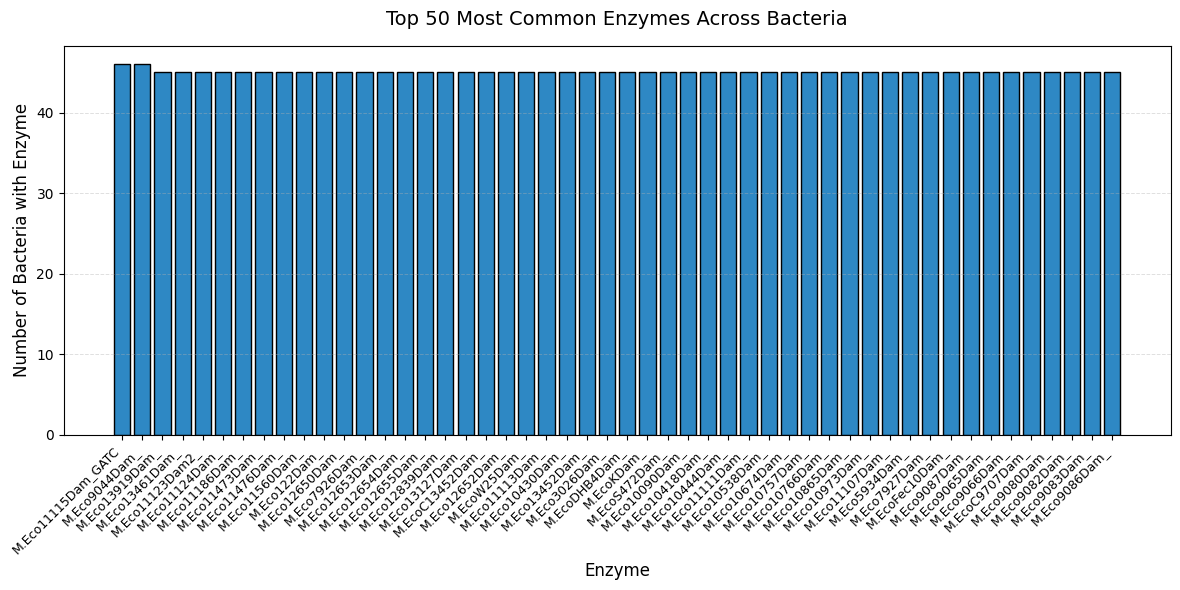

In [24]:
top_n = 50
top_enzymes = enzyme_counts.head(top_n)


enzymes_original = top_enzymes.index.tolist()

enzymes_clean = []
for i, name in enumerate(enzymes_original):
    if i == 0:
        enzymes_clean.append(name)
    else:
        new_name = re.sub(r"\s*GATC$", "", name)
        enzymes_clean.append(new_name)



plt.figure(figsize=(12, 6))  
plt.bar(
    x=range(len(enzymes_clean)),   
    height=top_enzymes.values,     
    color='#2e88c4',
    edgecolor='k'
)

plt.xlabel('Enzyme', fontsize=12)
plt.ylabel('Number of Bacteria with Enzyme', fontsize=12)
plt.title(f'Top {top_n} Most Common Enzymes Across Bacteria', fontsize=14, pad=15)


plt.xticks(
    ticks=range(len(enzymes_clean)),
    labels=enzymes_clean,
    rotation=45,
    ha='right',
    fontsize=9
)


plt.grid(axis='y', linestyle='--', alpha=0.4, linewidth=0.7)

plt.tight_layout()
plt.show()


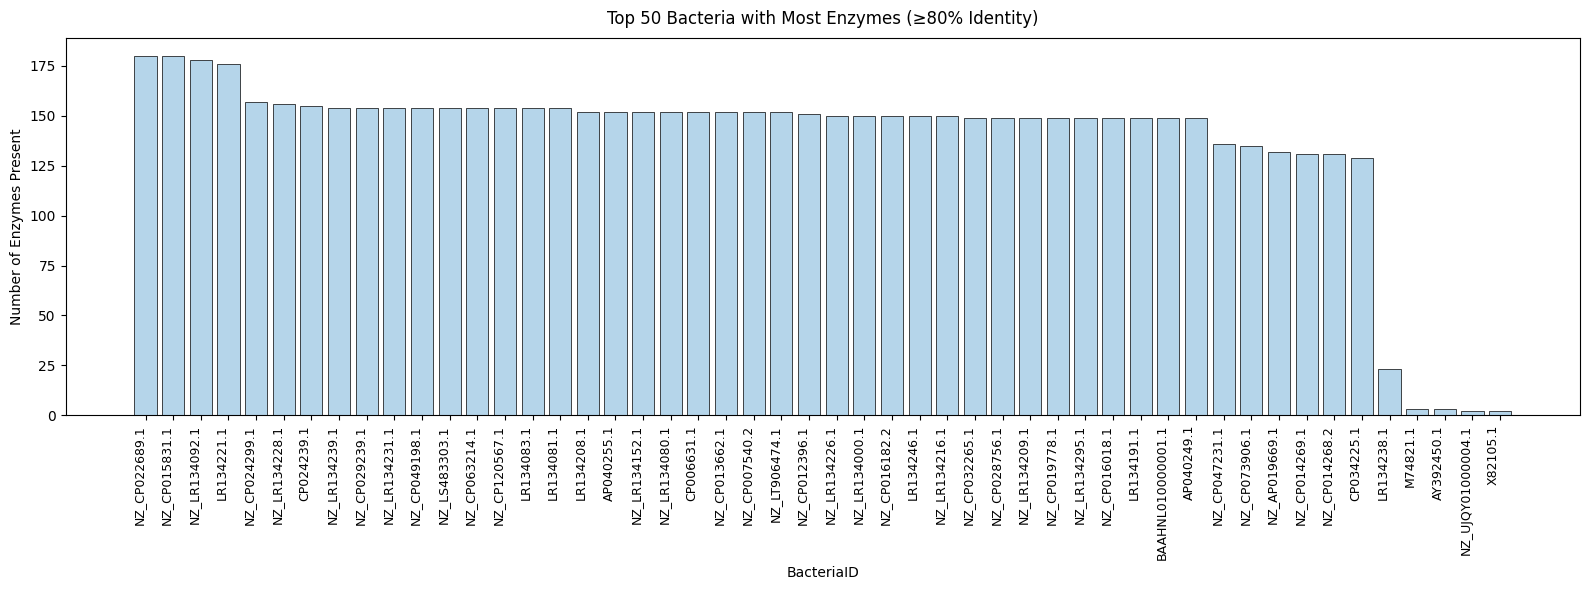

In [25]:
# Top 50 bacteria with the most enzymes present
top_bacteria = bacteria_counts.head(top_n)

plt.figure(figsize=(16, 6))  
plt.bar(top_bacteria.index, top_bacteria.values, color='#b5d5ea', edgecolor='k', linewidth=0.5)

plt.xlabel('BacteriaID', fontsize=10)
plt.ylabel('Number of Enzymes Present', fontsize=10)
plt.title(f'Top {top_n} Bacteria with Most Enzymes (≥80% Identity)', fontsize=12, pad=10)


plt.xticks(
    ticks = range(len(top_bacteria.index)),
    labels = top_bacteria.index,
    rotation = 90,
    ha = 'right',
    fontsize = 9
)


plt.subplots_adjust(bottom=0.40)

plt.tight_layout()
plt.show()

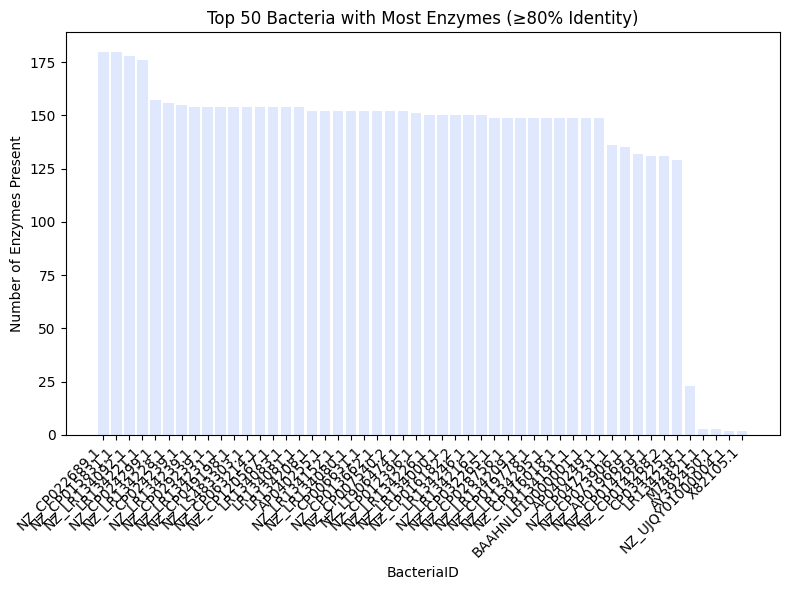

In [26]:
# Top 50 bacteria with the most enzymes present
top_bacteria = bacteria_counts.head(top_n)

plt.figure(figsize=(8, 6))
plt.bar(top_bacteria.index, top_bacteria.values, color='#dfe8fc')
plt.xlabel('BacteriaID')
plt.ylabel('Number of Enzymes Present')
plt.title(f'Top {top_n} Bacteria with Most Enzymes (≥80% Identity)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Categorizing Enzymes by Restriction Type

In this step, we load the cleaned enzyme dataset and identify each enzyme’s class (Type I, II, III, or IV) by examining the suffix of its name. 

By extracting and appending this “ENZYME TYPE” column, we can later analyze the distribution and functional differences between the various restriction‐enzyme classes across our dataset.


In [27]:
# Load the CSV file
grouped_enzymes_df = pd.read_csv("enzyme_data_clean_from_txt.csv")

# Clean enzyme names by stripping whitespace
grouped_enzymes_df['ENZYME NAME'] = grouped_enzymes_df['ENZYME NAME'].str.strip()

# Extract enzyme type from the suffix (I, II, III, or IV)
def extract_enzyme_type(name):
    match = re.search(r'(I{1,3}|IV)$', name)
    return match.group(0) if match else None

# Apply extraction to each row
grouped_enzymes_df['ENZYME TYPE'] = grouped_enzymes_df['ENZYME NAME'].apply(extract_enzyme_type)

# Save the result (optional)
grouped_enzymes_df.to_csv("grouped_enzymes_with_type.csv", index=False)


In [28]:
# Count frequency of each enzyme type
enzyme_type_counts = grouped_enzymes_df['ENZYME TYPE'].value_counts()
print(enzyme_type_counts)

ENZYME TYPE
I      235
II      39
III      8
IV       2
Name: count, dtype: int64


## Statistical Analyses of Restriction‐Enzyme Data

Below are the key results from our statistical analyses, accompanied by bar plots and a summary table. Each subsection contains a brief introduction to the analysis and the code used to generate it.

---

### Distribution of Enzyme Types

To understand how restriction enzymes are distributed among different classes (Type I, II, III, IV), we counted the number of enzyme entries in each category and plotted the results:

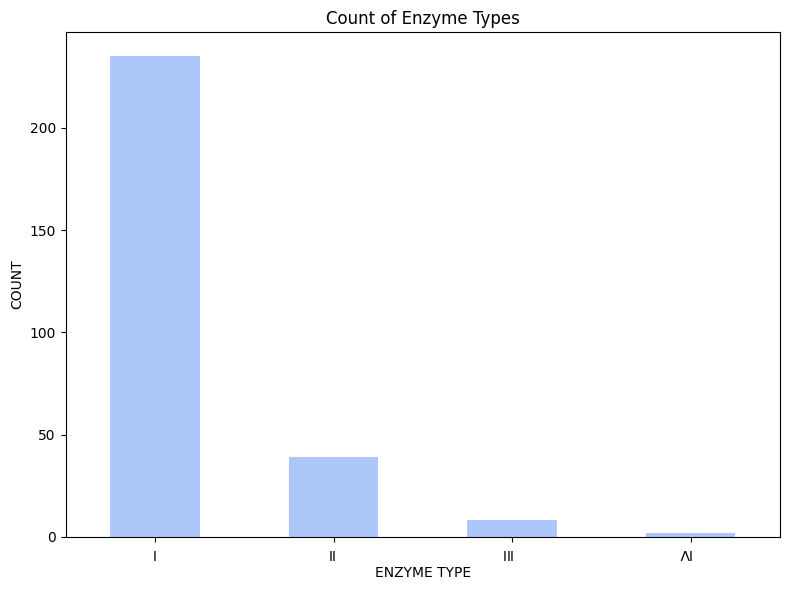

In [29]:
df = pd.read_csv('grouped_enzymes_with_type.csv')  

counts = df['ENZYME TYPE'].value_counts()

plt.figure(figsize=(8, 6))
counts.plot(
    kind='bar',
    color = '#aec7fa'  
)
plt.xlabel('ENZYME TYPE')
plt.ylabel('COUNT')
plt.title('Count of Enzyme Types')
plt.xticks(rotation = 180, ha='right')
plt.tight_layout()
plt.show()


### Top 30 Most Avoided Enzymes
Next, we calculated how often each enzyme recognition site was “avoided” in phage genomes (i.e., the number of phages in which a given site was underrepresented). We then plotted the 30 enzymes with the highest avoidance counts:

/var/folders/07/0gss62m90c3739dzjgm3m0pr0000gn/T/ipykernel_25517/4286603264.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/07/0gss62m90c3739dzjgm3m0pr0000gn/T/ipykernel_25517/4286603264.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


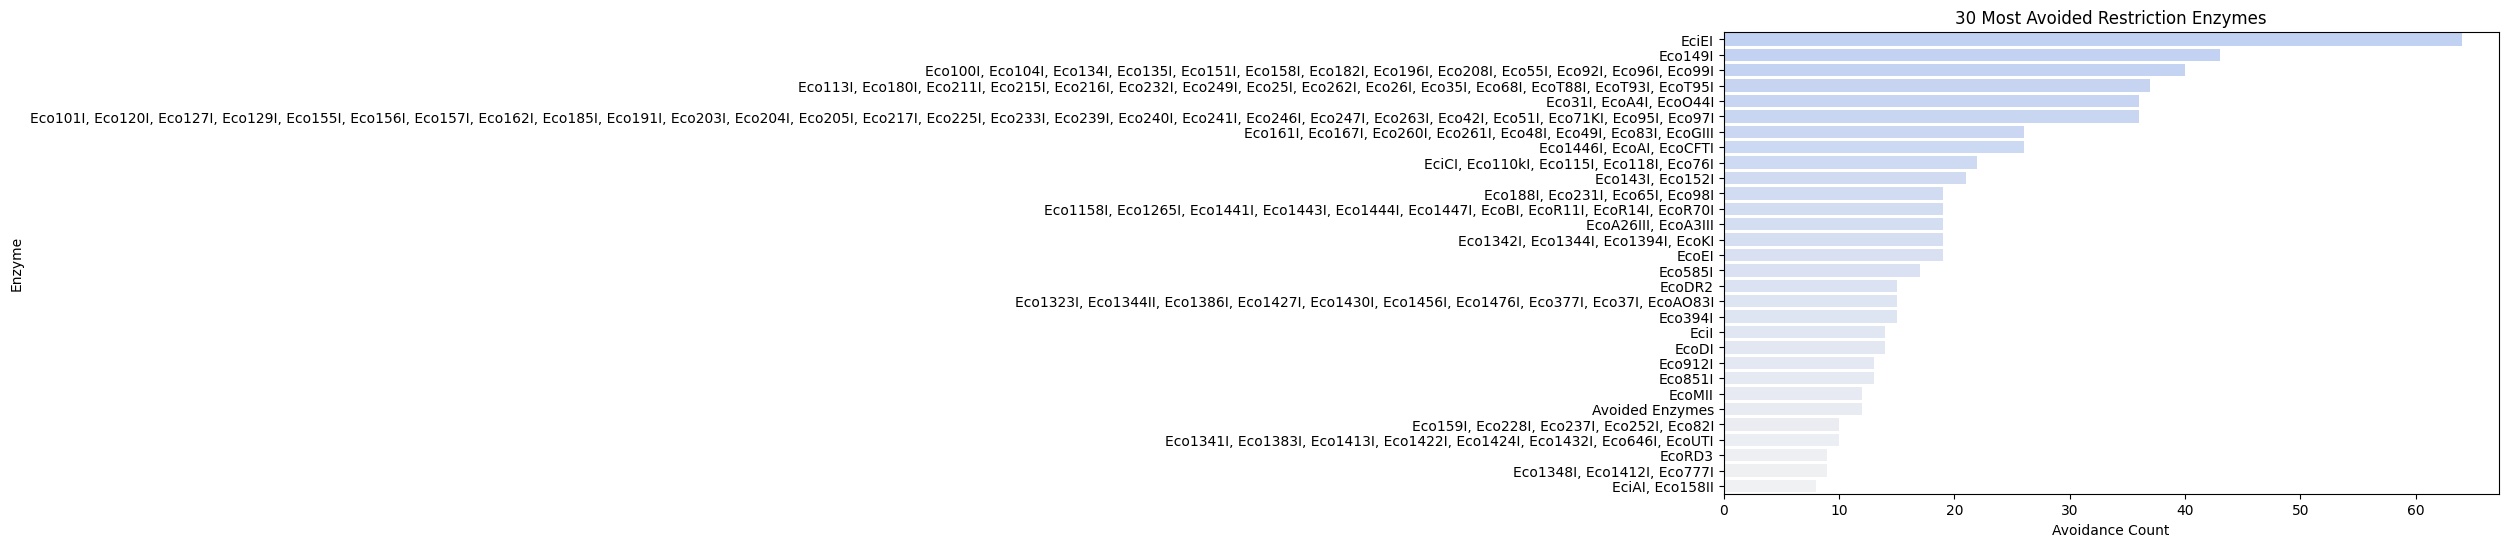

In [30]:
# Load the CSV file
df = pd.read_csv("enzyme_avoidance_counts.csv")
df.columns = ['Enzyme', 'Avoidance_Count']

# Sort and get the 30 most avoided enzymes
top_enzymes = df.sort_values(by='Avoidance_Count', ascending=False).head(30)

base_color = "#b9cefa" 
monochrome_palette = sns.light_palette(base_color, n_colors=30, reverse=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Avoidance_Count',
    y='Enzyme',
    data=top_enzymes,
    palette= monochrome_palette[:len(top_enzymes)]  # Ensure matching number
)
plt.title('30 Most Avoided Restriction Enzymes')
plt.xlabel('Avoidance Count')
plt.ylabel('Enzyme')
plt.tight_layout()
plt.show()


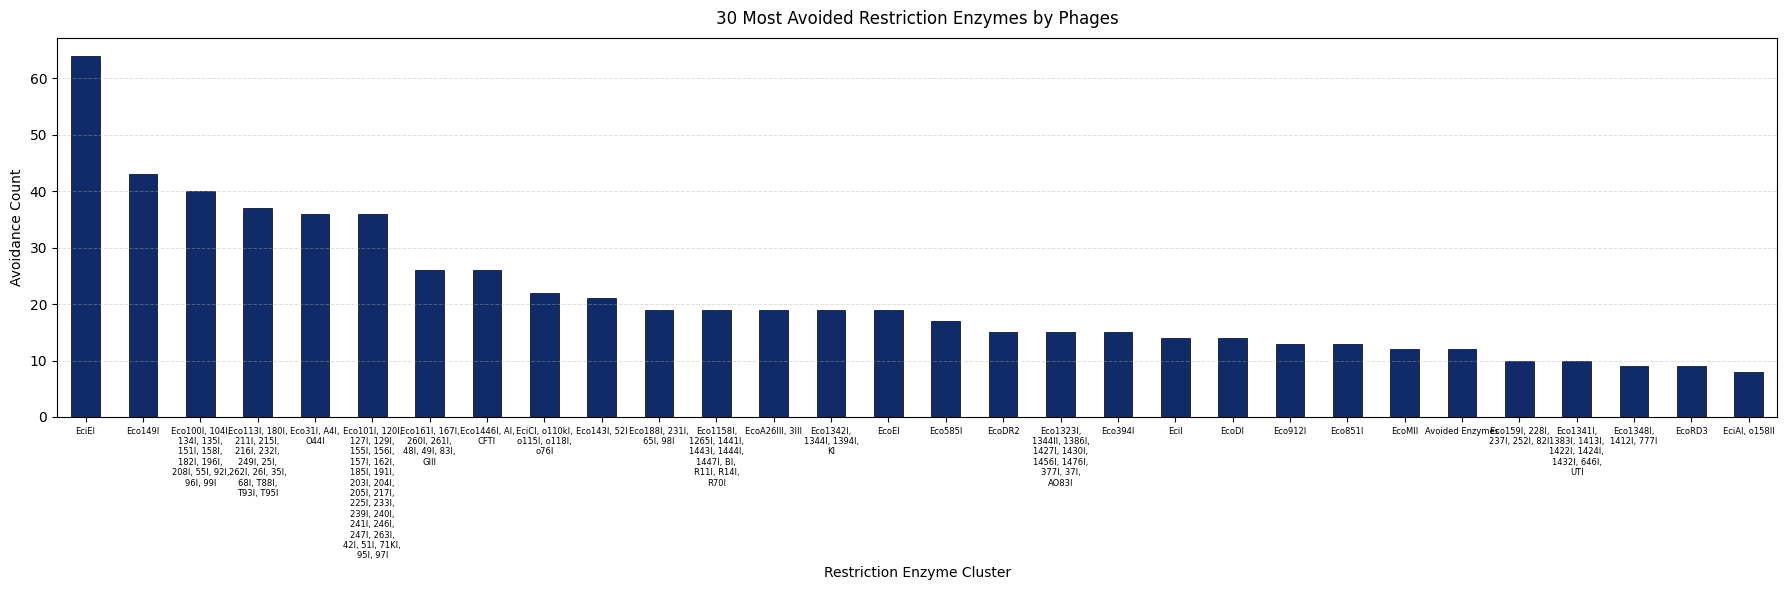

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import textwrap


df = pd.read_csv(
    'enzyme_avoidance_counts.csv',
    header=None,
    names=["EnzymeGroup", "Count"]
)


df_sorted = df.sort_values(by="Count", ascending=False).reset_index(drop=True)
top30 = df_sorted.head(30)


def longest_common_prefix(strs):
    if not strs:
        return ""
    prefix = strs[0]
    for s in strs[1:]:
        while not s.startswith(prefix) and prefix:
            prefix = prefix[:-1]
        if not prefix:
            break
    return prefix


def compress_group(group_str):
    enzymes = [e.strip() for e in group_str.split(",")]
    if len(enzymes) <= 1:
        return group_str
    prefix = longest_common_prefix(enzymes)
    if len(prefix) < 2:
        return group_str

    compressed = [enzymes[0]]
    for e in enzymes[1:]:
        if e.startswith(prefix):
            compressed.append(e[len(prefix):])
        else:
            compressed.append(e)
    return ", ".join(compressed)


def wrap_label(s, width=15):
    return textwrap.fill(s, width=width)


compressed_labels = [compress_group(x) for x in top30["EnzymeGroup"]]
wrapped_labels = [wrap_label(x, width=15) for x in compressed_labels]


enzyme_series = pd.Series(
    data=top30["Count"].values,
    index=wrapped_labels
)

plt.figure(figsize=(18, 6))  
ax = enzyme_series.plot(
    kind='bar',
    color='#112b68',
    edgecolor='k',
    linewidth=0.5
)

ax.set_xticklabels(
    wrapped_labels,
    rotation=360,
    ha='center',
    fontsize=6,
    
)


ax.set_xlabel("Restriction Enzyme Cluster", fontsize=10)
ax.set_ylabel("Avoidance Count", fontsize=10)
ax.set_title("30 Most Avoided Restriction Enzymes by Phages", fontsize=12, pad=10)


plt.subplots_adjust(bottom=0.40)


ax.yaxis.grid(True, linestyle='--', alpha=0.4, linewidth=0.7)

plt.tight_layout()
plt.show()


### Average Cut Sites per Phage
We also computed, for each phage, the mean number of restriction‐enzyme cut sites detected. The following code calculates the per‐phage average and plots the results:

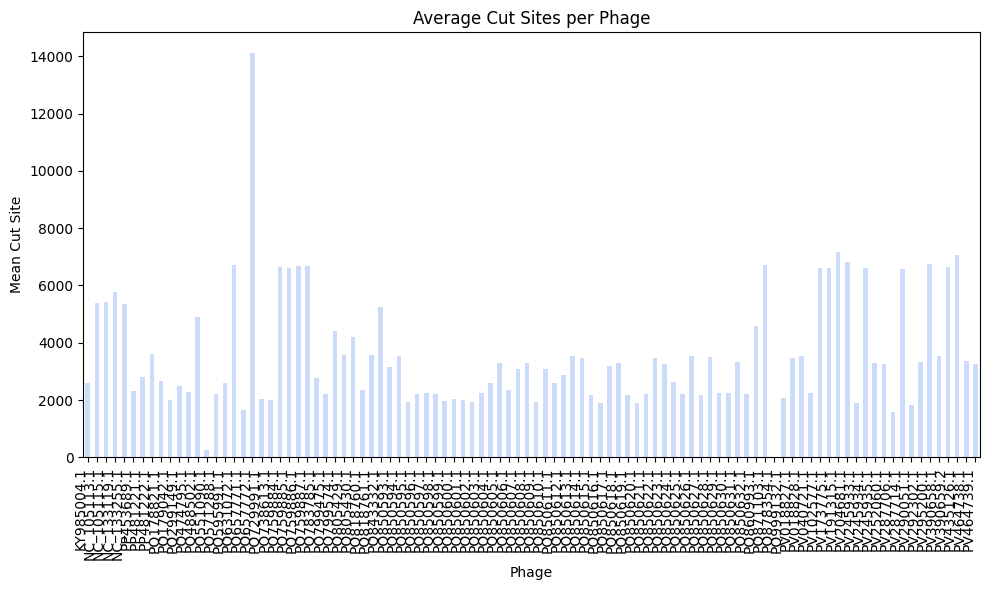

In [32]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('phage_enzyme_matrix.csv', index_col=0)


means = df.mean(axis=1)


plt.figure(figsize=(10, 6))
means.plot(
    kind='bar',
    color='#cddbfb'
)
plt.xlabel('Phage')
plt.ylabel('Mean Cut Site')
plt.title('Average Cut Sites per Phage')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


Computed the average number of restriction‐enzyme cut sites per phage using only the enzymes encoded by each host.

In [33]:
def compute_average_cuts(
    phage_host_mapped_csv: str,
    enzyme_bacteria_map_csv: str,
    phage_enzyme_matrix_csv: str,
    out_csv: str,
    plot: bool = True
) -> None:
  

    df_phage_map = pd.read_csv(phage_host_mapped_csv)
    df_enz_bac   = pd.read_csv(enzyme_bacteria_map_csv)
    site_matrix  = pd.read_csv(phage_enzyme_matrix_csv, index_col=0)


    df_enzyme_to_bacs = df_enz_bac.groupby("Enzyme")["BacteriaID"].agg(list)

    mean_cuts = {}
    for phage in site_matrix.index:
        rows = df_phage_map[df_phage_map["Phage"] == phage]
        if rows.empty or rows["BacteriaID"].isna().all():
            mean_cuts[phage] = np.nan
            continue

        host_ids = rows["BacteriaID"].dropna().unique().tolist()

        enzimas_do_host = set()
        for hid in host_ids:
            for enz, bac_list in df_enzyme_to_bacs.items():
                if hid in bac_list:
                    
                    sem_m = enz.replace("M.", "")    
                    base  = sem_m.split("_")[0]      
                    enz_norm = base.strip()          
                    enzimas_do_host.add(enz_norm)

       
        valid_enz = [e for e in enzimas_do_host if e in site_matrix.columns]

        
        if not valid_enz:
            mean_cuts[phage] = np.nan
        else:
            sublinha = site_matrix.loc[phage, valid_enz]
            mean_cuts[phage] = sublinha.mean()

    
    mean_series = pd.Series(mean_cuts).sort_values()
    df_result   = mean_series.reset_index()
    df_result.columns = ["Phage", "Mean_Cut_Sites_HostOnly"]
    df_result.to_csv(out_csv, index=False)
    print(f"[+] Saved: '{out_csv}' ({len(df_result)} lines)\n")

    if plot:
        num_valid = mean_series.count()  
        print(f"There are {num_valid} phages with non-NaN means (out of {len(mean_series)})")
        if num_valid == 0:
            print("No valid values to plot (all are NaN).")
            return

        plt.figure(figsize=(18, 6))  

        ax = mean_series.plot(
            kind="bar",
            color="#cddbfb",
            edgecolor="k",
            linewidth=0.5
        )

        
        ax.set_xticklabels(
            mean_series.index, 
            rotation=90, 
            ha="right", 
            fontsize=6, 
            fontweight='bold'
        )

        ax.set_xlabel("Phage", fontsize=10)
        ax.set_ylabel("Mean Cut Sites\n(enzymes encoded by host)", fontsize=10)
        ax.set_title("Average Cut Sites per Phage – only host-encoded enzymes", fontsize=12, pad=10)

        # Reserva parte do espaço inferior para não cortar os últimos rótulos
        plt.subplots_adjust(bottom=0.40)

        # Grade leve no eixo Y (opcional)
        ax.yaxis.grid(True, linestyle="--", alpha=0.4, linewidth=0.7)

        plt.tight_layout()
        plt.show()


[+] Saved: 'average_cuts_per_phage_host_only.csv' (98 lines)

There are 88 phages with non-NaN means (out of 98)


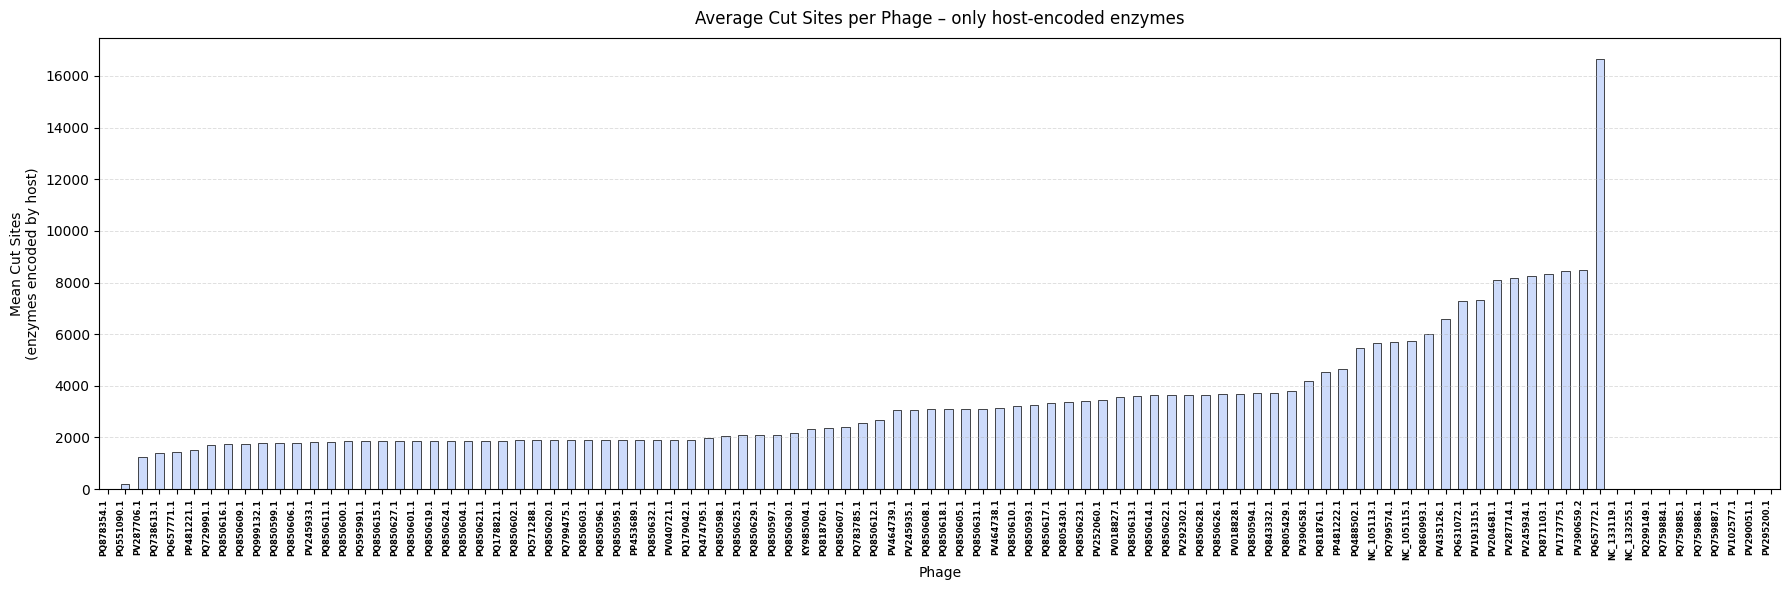

In [34]:
compute_average_cuts(
    phage_host_mapped_csv="phage_host_mapeado.csv",
    enzyme_bacteria_map_csv="enzyme_bacteria_map.csv",
    phage_enzyme_matrix_csv="phage_enzyme_matrix.csv",
    out_csv="average_cuts_per_phage_host_only.csv",
    plot=True
)
